# Tutorial on the Visium SPG DLPFC dataset

This tutorial demonstrates how to run proust on sample Br6432 from the Visium SPG DLPFC dataset to identify spatial domains. Here, we incorporate five channels (DAPI, NeuN, OLIG2, GFAP, and TMEM119) from the immunofluorescence protein image with the spatially resolved transcriptomics. Please download the source data from the Globus endpoint 'jhpce#spatialDLPFC' at [http://research.libd.org/globus/](http://research.libd.org/globus/). GPU is recommended to run proust for the most efficient performance. 

## Step 0: import dependencies and proust

In [2]:
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import imageio
from numpy import newaxis
import os

from proust.Train import *
from proust.cluster import *
from proust.prep import *

/users/jyao/.conda/envs/proust-310/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Step 1: set environment and load data

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] = '/users/jyao/.conda/envs/proust-310/lib/R' #replace with your R_HOME path

seed = 1998
dataset = '6432'
n_clusters = '7' #predefined number of clusters

In [4]:
print("################################ IF-" + str(dataset) + " #####################################")
file_fold = '../data/' + str(dataset)
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True) #load Visium data
adata.var_names_make_unique()
image = imageio.volread("../data/" + str(dataset) + "/" + str(dataset) + ".tif") #load image
image = image[1:6, :, :]
x_pixel = adata.obsm['spatial'][:, 1].astype(int)
y_pixel = adata.obsm['spatial'][:, 0].astype(int)

################################ IF-6432 #####################################


/users/jyao/.conda/envs/proust-310/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Step 2: reconstruct protein and gene expression features using proust
We first extract image features, and then reconstruct protein and gene expression features using proust. We recommend using GPU in this step.

In [5]:
# Extract img features
Img_learn(adata, image, device=device)
print("Finish extracting image features!")
# Reconstruct protein and gene features
model = proust(adata, device=device, random_seed=seed)
adata = model.train()

Image dimension r:  66


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.08it/s]


Finish extracting image features!
Begin to train spatial transcriptomics data


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 58.60it/s]


Optimization finished for ST data!
Begin to train protein information


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:13<00:00, 43.07it/s]

Optimization finished for protein profile!


## Step 3: identify spatial domains with the hybrid profile
Next, we perform clustering to detect spatial domains using the hybrid profile created from the reconstructed features. Proust also offers an optional refinement step in which a given spot is relabeled to the most common spatial domain of its r nearest surrounding spots. Here, we set radius = 50 in this Visium SPG DLPFC sample. 

In [12]:
# define radius to limit the number of neighbors during refinement
radius = 50
adata = clustering(adata, n_clusters=n_clusters, radius=radius, gene_pcs=30, image_pcs=5, refinement=True, seed=seed)

fitting ...
  |======================================================================| 100%


## Visualization

/users/jyao/.conda/envs/proust-310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/users/jyao/.conda/envs/proust-310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


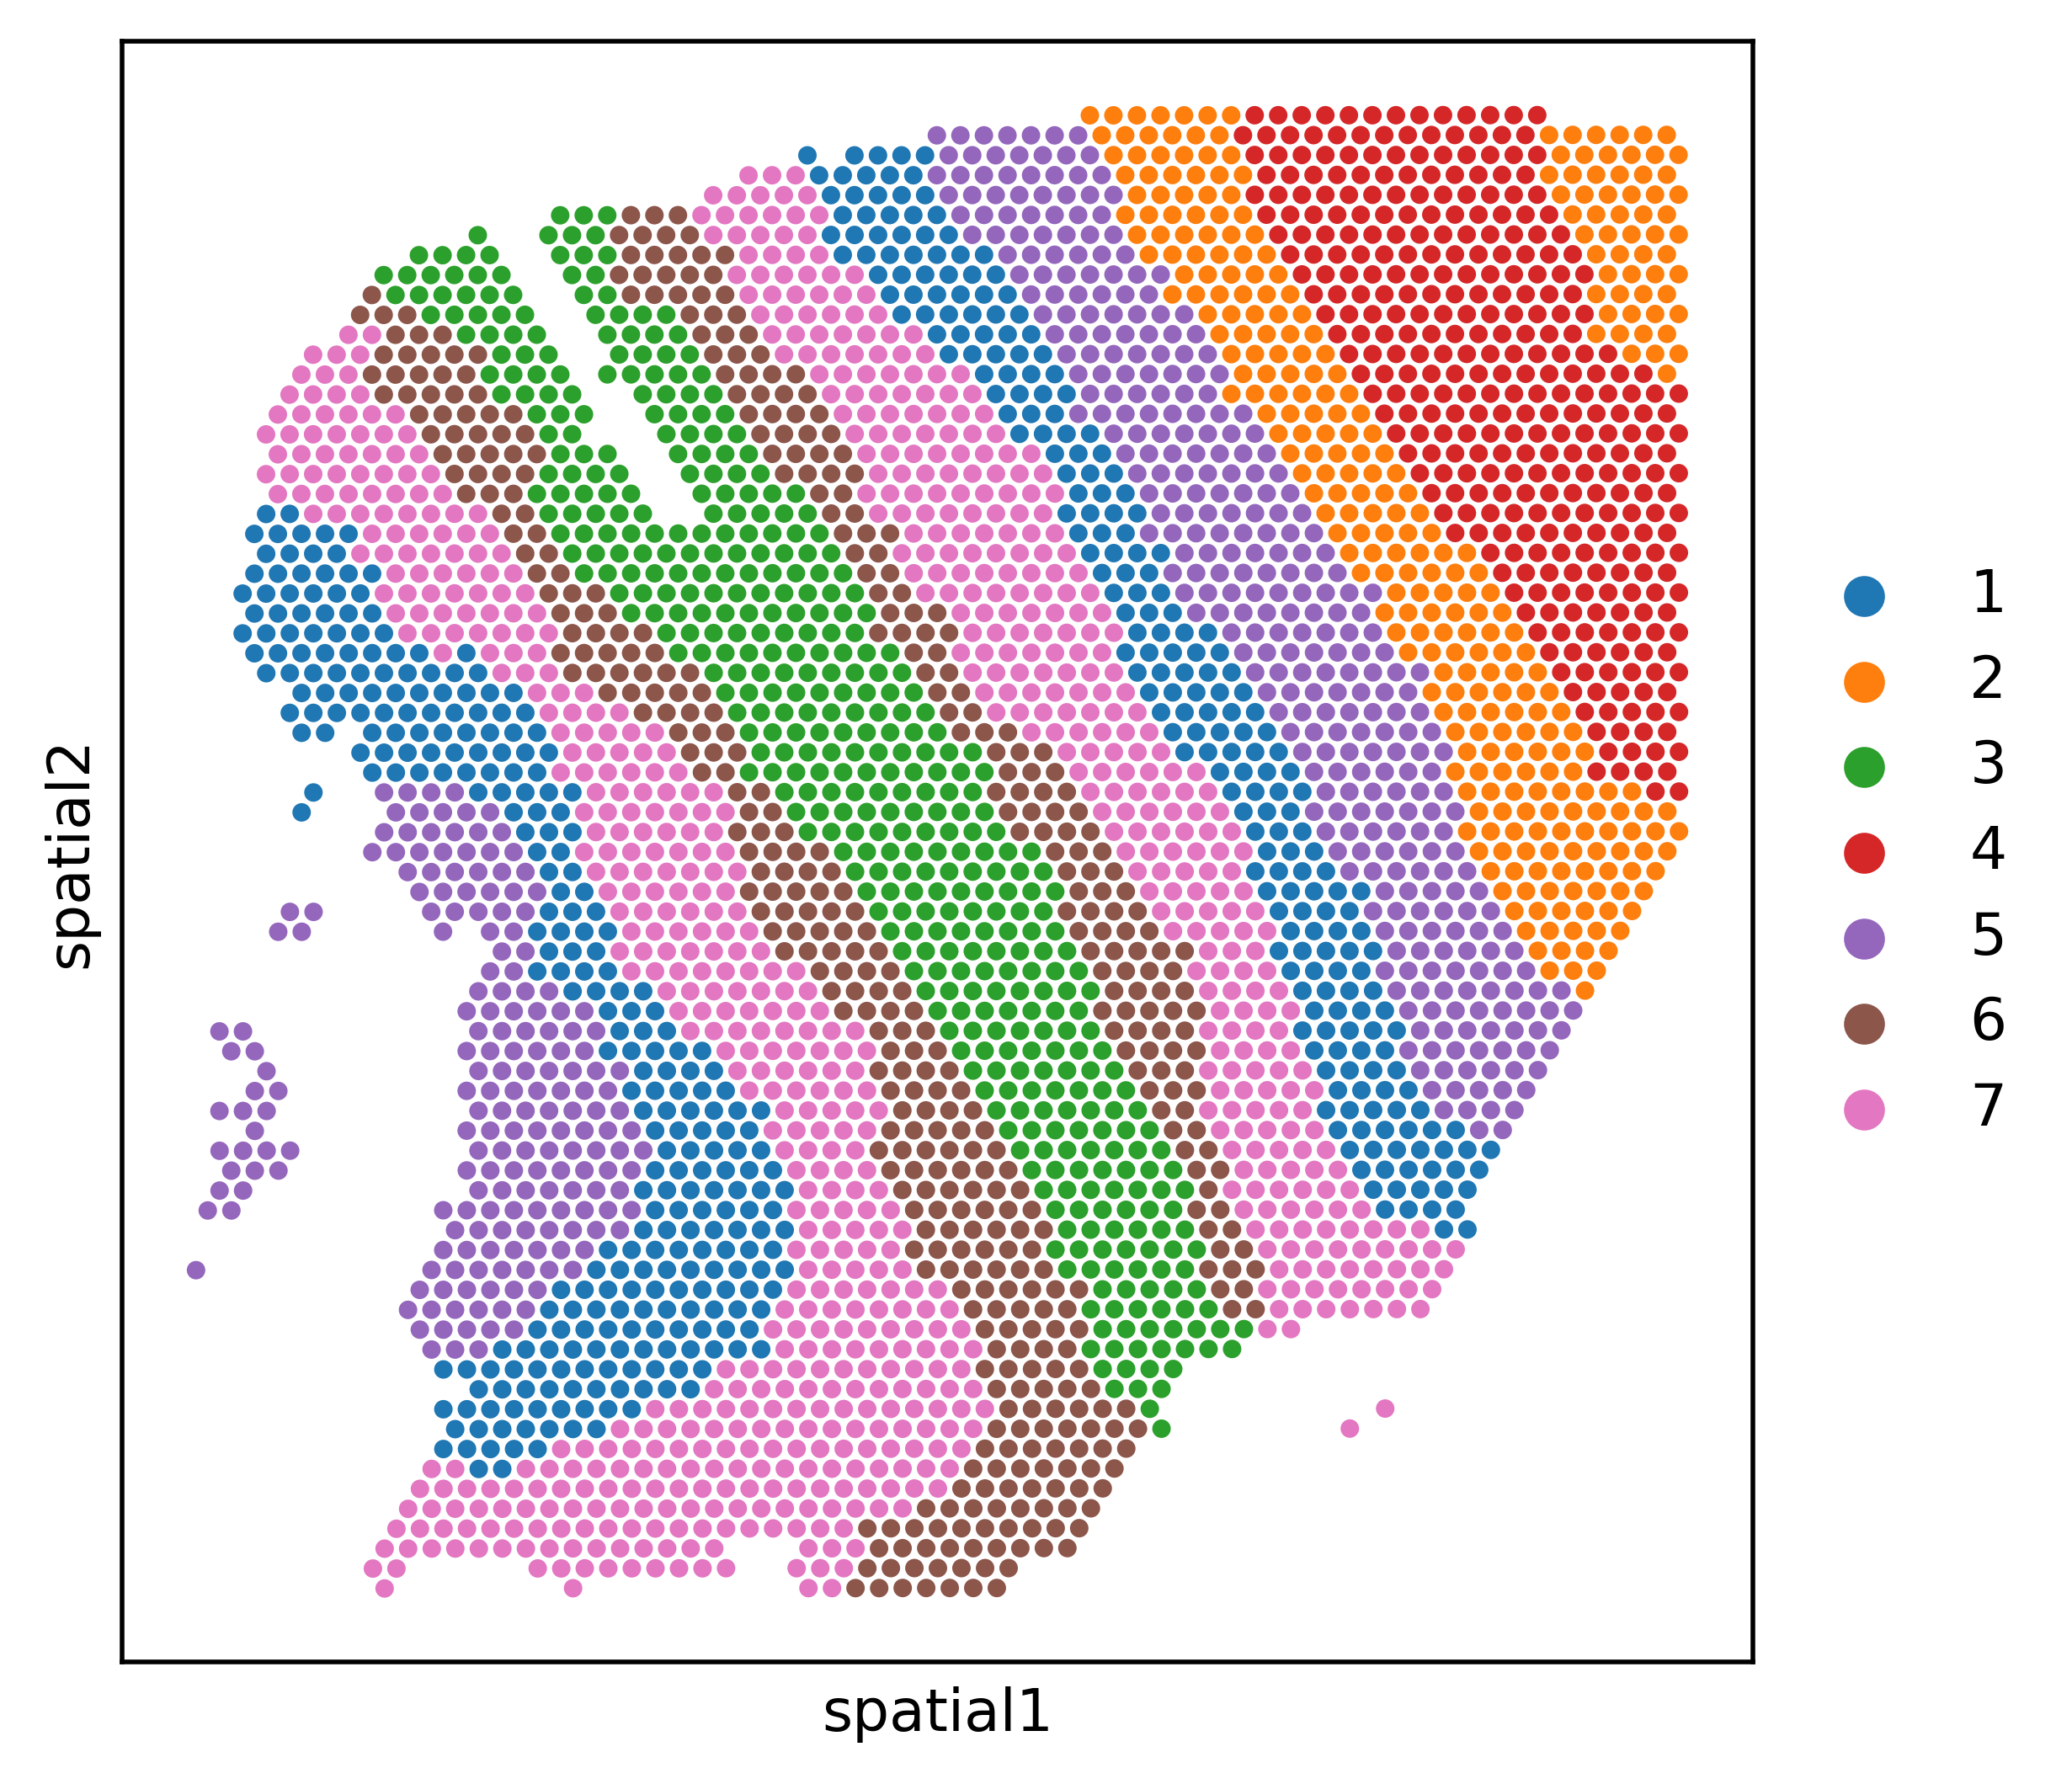

In [14]:
adata.obsm['spatial'][:, 1] = -1 * adata.obsm['spatial'][:, 1]
adata.obsm['spatial'] = adata.obsm['spatial'].astype(int)

dpi = 500
fig, ax = plt.subplots(figsize=(5, 5), dpi=dpi)
sc.pl.embedding(adata,
                basis="spatial",
                color="cluster_profile",
                size=40,
                show=False,
                ax=ax)
ax.set_title('')
plt.show()
plt.close()